In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# define constants
IMG_H = 28
IMG_W = 28
NUM_DIGITS = 10
INTENSITY_THRESHOLD = 127

# read data
data_frame = pd.read_csv("mnist_train.csv",dtype=np.int32,header=None)
NUM_TRAIN_IMAGES = data_frame.shape[0]
NUM_PIXELS = data_frame.shape[1]-1
    

In [2]:
# re-format data
def reformat_data(data_frame):
    np_data_frame = data_frame.values
    images = np_data_frame[:,1:]
    labels = np_data_frame[:,0]
    
    return [images, labels]

[images_train, labels_train] = reformat_data(data_frame)


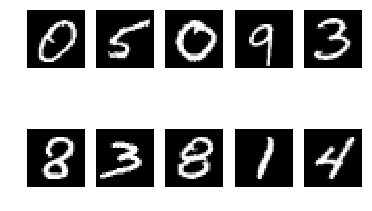

In [3]:
# plot data as a sanity check
%matplotlib inline
NUM_PLOTS = 10
sample_idx = np.random.randint(0,NUM_TRAIN_IMAGES,(NUM_PLOTS))

for i in range(0,NUM_PLOTS):
    plt.subplot(2,5,i+1)
    plt.imshow(np.reshape(images_train[sample_idx[i],:],(IMG_H,IMG_W)),cmap='gray')
    plt.axis('off')

plt.show()


In [4]:
def preprocess_dataset(images, labels):
    images_ordered = np.empty_like(images)
    images_threshold = np.empty_like(images)

    # order images by label and threshold
    label_indices = np.argsort(labels)
    labels_sorted = labels[label_indices]
    images_sorted = images[label_indices,:]
    images_threshold = np.where(images_sorted > INTENSITY_THRESHOLD, 1, 0)
    
    return [images_threshold, labels_sorted]
    
def compute_probability(images_threshold, labels, NUM_DIGITS, NUM_PIXELS):
    digit_freq = np.empty((NUM_DIGITS),dtype=np.int32)
    pixel_freq_ones = np.empty((NUM_DIGITS,NUM_PIXELS),dtype=np.int32)
    
    # compute probability of each digit in train set
    digit_freq = np.bincount(labels)
    idx = np.insert(np.cumsum(digit_freq), 0, 0)
    
    # compute pixel probabilities
    for digit in range(0,NUM_DIGITS):
        pixel_freq_ones[digit,:] = np.sum(images_threshold[idx[digit]:idx[digit+1]-1,:],axis=0)
    
    pixel_freq_zeros = (np.reshape(digit_freq,(digit_freq.size,1)).T - pixel_freq_ones.T).T
    pixel_freq = np.stack((pixel_freq_zeros / digit_freq[:,None], pixel_freq_ones / digit_freq[:,None]), axis=-1)
    return [digit_freq / NUM_TRAIN_IMAGES, pixel_freq]
    
# preprocess the dataset then compute probabilities
[images_threshold_train, labels_sorted_train] = preprocess_dataset(images_train, labels_train)
[digit_freq, pixel_freq] = compute_probability(
    images_threshold_train, labels_sorted_train, NUM_DIGITS, NUM_PIXELS)


In [5]:
# compute test set probabilities
data_frame = pd.read_csv("mnist_test.csv",dtype=np.int32,header=None)
NUM_IMAGES_TEST = data_frame.shape[0]

# separate the data
[images_test, labels_test] = reformat_data(data_frame)

# preprocess test set
[images_threshold_test, labels_sorted_test] = preprocess_dataset(images_test, labels_test)


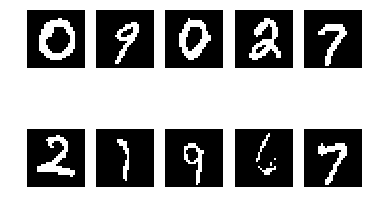

In [6]:
# plot data as a sanity check
%matplotlib inline
NUM_PLOTS = 10
sample_idx = np.random.randint(0,NUM_IMAGES_TEST,(NUM_PLOTS))

for i in range(0,NUM_PLOTS):
    plt.subplot(2,5,i+1)
    plt.imshow(np.reshape(images_threshold_test[sample_idx[i],:],(IMG_H,IMG_W)),cmap='gray')
    plt.axis('off')

plt.show()


In [7]:
posterior = np.empty((NUM_IMAGES_TEST, NUM_DIGITS))
label_predicted = np.empty((NUM_IMAGES_TEST))

for idx in range(0, NUM_IMAGES_TEST):
    likelihood = np.empty((NUM_DIGITS, NUM_PIXELS))
    curr_image = np.int32(images_threshold_test[idx,:])
    inv_curr_image = 1 - curr_image
    
    # compute the likelihood
    image_stack = np.stack((inv_curr_image, curr_image), axis=-1)
    pixel_intensity = np.repeat(image_stack[np.newaxis], NUM_DIGITS, axis=0)
    likelihood = np.sum(np.multiply(pixel_freq, pixel_intensity), axis=2)
    
    # compute marginal probability
    marginal = np.sum(np.prod(likelihood,axis=1) * digit_freq)
    
    # compute posterior probabilities and get predicted label
    posterior[idx] = np.prod(likelihood,axis=1) * digit_freq / np.prod(marginal)
    label_predicted[idx] = np.argmax(posterior[idx])
    
accuracy = np.sum(label_predicted == labels_sorted_test) / NUM_IMAGES_TEST * 100
accuracy

F:\Programming Tools\Anaconda 2\envs\python36\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


84.340000000000003

In [ ]:
digit_freq

In [ ]:
pixel_freq[0,:,0] * digit_freq[0] * NUM_TRAIN_IMAGES

In [ ]:
np.where(pixel_freq[0,:,0] * digit_freq[0] * NUM_TRAIN_IMAGES == 1323)

In [8]:
[pixel_freq[0,213,0], pixel_freq[5,523,0], pixel_freq[7,689,1], pixel_freq[1,497,1],pixel_freq[1,150,1]]

[0.22336653722775621,
 0.65947242206235013,
 0.10534716679968077,
 0.0011865915158706616,
 0.013497478493028774]

In [9]:
[pixel_freq[9,745,0],pixel_freq[8,652,0],pixel_freq[3,378,1],pixel_freq[2,219,0],pixel_freq[4,72,1]]

[0.95528660279038491,
 0.73252435481114342,
 0.80003262110585549,
 0.98237663645518636,
 0.00034234851078397807]